In [1]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas

import cmocean

# Load shards
df = pandas.read_csv('../data/FitShards_red.csv')
names = df.group_id
nshards = size(names)
velocities = zeros(shape=(nshards,3))
dispersions = zeros(shape=(nshards,3))
velocities[0:(nshards),0] = df.vx # stream velocities
velocities[0:(nshards),1] = df.vy
velocities[0:(nshards),2] = df.vz
dispersions[0:(nshards),0] = df.sigx # dispersion tensors
dispersions[0:(nshards),1] = df.sigy
dispersions[0:(nshards),2] = df.sigz
pops = df.population
Psun = df.Psun
weights = ShardsWeights(names,pops,Psun)

# Halo params
HaloModel = SHMpp
v0 = HaloModel.RotationSpeed
v_esc = HaloModel.EscapeSpeed
sig_beta = HaloModel.SausageDispersionTensor
sig_iso = array([1.0,1.0,1.0])*v0/sqrt(2.0)
day = 67.0 

In [42]:
from WIMPFuncs import *


n = 100
nn = int(n*n/2)
ph = linspace(0, 2*pi, n)
th = linspace(-pi/2, pi/2, int(n/2))
PH, TH = meshgrid(ph,th)
X = cos(PH)*cos(TH)
Y = -sin(PH)*cos(TH)
Z = -sin(TH)
ii = 0
q = zeros(shape=(nn,3))
for i in range(0,int(n/2)):
    for j in range(0,n):
        q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
        ii = ii+1

# Benchmark
ne = 100
nbins = 3
E = zeros(shape=(nbins,ne))
E[0,:] = linspace(5.0,10.0,ne)
E[1,:] = linspace(10.0,20.0,ne)
E[2,:] = linspace(20.0,50.0,ne)

m_chi = 100.0
sigma_p = 1.0e-46
A = F19.MassNumber
eta = 0.2

# Radon transform and rate
dR_smooth = zeros(shape=(3,nn))
dR_shards = zeros(shape=(3,nn))
fhat0 = zeros(shape=(nn))
for ibin in range(0,nbins):
    E_r = E[ibin,:]
    v_min = MinimumWIMPSpeed(E_r,A,m_chi)
    for ie in range(0,ne):
        fhat0 = fhat_Isotropic(v_min[ie],-1.0*q,day)
        dR_smooth[ibin,:] += (1-eta)*diffRecoilRate_SI(E_r[ie],fhat0,A,sigma_p,m_chi)
        fhat_saus = fhat_Triaxial(v_min[ie],-1.0*q,day,sig_beta)
        dR_smooth[ibin,:] += eta*diffRecoilRate_SI(E_r[ie],fhat_saus,A,sigma_p,m_chi)
        
        fhat = zeros(shape=(nn))
        for i in range(0,nshards):
            v_s = velocities[i,:]
            sig_s = dispersions[i,:]
            fhat += weights[i]*fhat_Triaxial(v_min[ie],-1.0*q,day,sig_s,v_shift=v_s)
        dR_shards[ibin,:] += diffRecoilRate_SI(E_r[ie],fhat,A,sigma_p,m_chi)
    print('bin =',ibin)

    

# Convert list into Mollweide map
dR_map_smooth = zeros(shape=(int(n/2),n,3))
dR_map_shards = zeros(shape=(int(n/2),n,3))
for ibin in range(0,3):
    ii = 0
    for i in range(0,int(n/2)):
        for j in range(0,n):
            dR_map_smooth[i,j,ibin] = dR_smooth[ibin,ii]
            dR_map_shards[i,j,ibin] = dR_shards[ibin,ii]
            ii = ii+1
    dR_map_smooth[:,:,ibin] = flipud(dR_map_smooth[:,:,ibin])     
    dR_map_shards[:,:,ibin] = flipud(dR_map_shards[:,:,ibin])  
    

/Users/ciaranohare/Work/Zaragoza/HaloSpin/code/HaloFuncs.py:61: RuntimeWarning: invalid value encountered in double_scalars
  *erfi(v_esc/(sqrt(2)*sigr)*sqrt(beta/(1-beta)))

bin = 0
bin = 1
bin = 2


In [43]:
qq = zeros(shape=(int(n/2),n,3))
ii = 0
for i in range(0,int(n/2)):
    for j in range(0,n):
        qq[i,j,0] = q[ii,0]
        qq[i,j,1] = q[ii,1]
        qq[i,j,2] = q[ii,2]
        ii = ii+1

# Apply angular res.
sig_a = 20*pi/180.0
def angres(q0):
    gamma = q0[0]*qq[:,:,0]+q0[1]*qq[:,:,1]+q0[2]*qq[:,:,2]
    gamma[gamma>1] = 1.0
    gamma[gamma<-1] = -1.0
    gamma = arccos(gamma)
    return exp(-gamma**2.0/(2*sig_a**2.0))

def applyangres(dR_map):
    dR_map_s = zeros(shape=(int(n/2),n,3))
    for ibin in range(0,3):
        for i in range(0,int(n/2)):
            for j in range(0,n):
                K = angres(squeeze(qq[i,j,:]))
                Knorm = trapz(flipud(trapz(K,ph,axis=1)),flipud(sin(th)))
                dR_map_s[i,j,ibin] = trapz(flipud(trapz(K*dR_map[:,:,ibin],ph,axis=1)),flipud(sin(th)))/Knorm
                dR_map_s[i,j,ibin] = trapz(flipud(trapz(K*dR_map[:,:,ibin],ph,axis=1)),flipud(sin(th)))/Knorm

    return dR_map_s
                
dR_map_smooth_s = applyangres(dR_map_smooth)
dR_map_shards_s = applyangres(dR_map_shards)
#dR_map_smooth_s = dR_map_smooth
#dR_map_shards_s = dR_map_shards

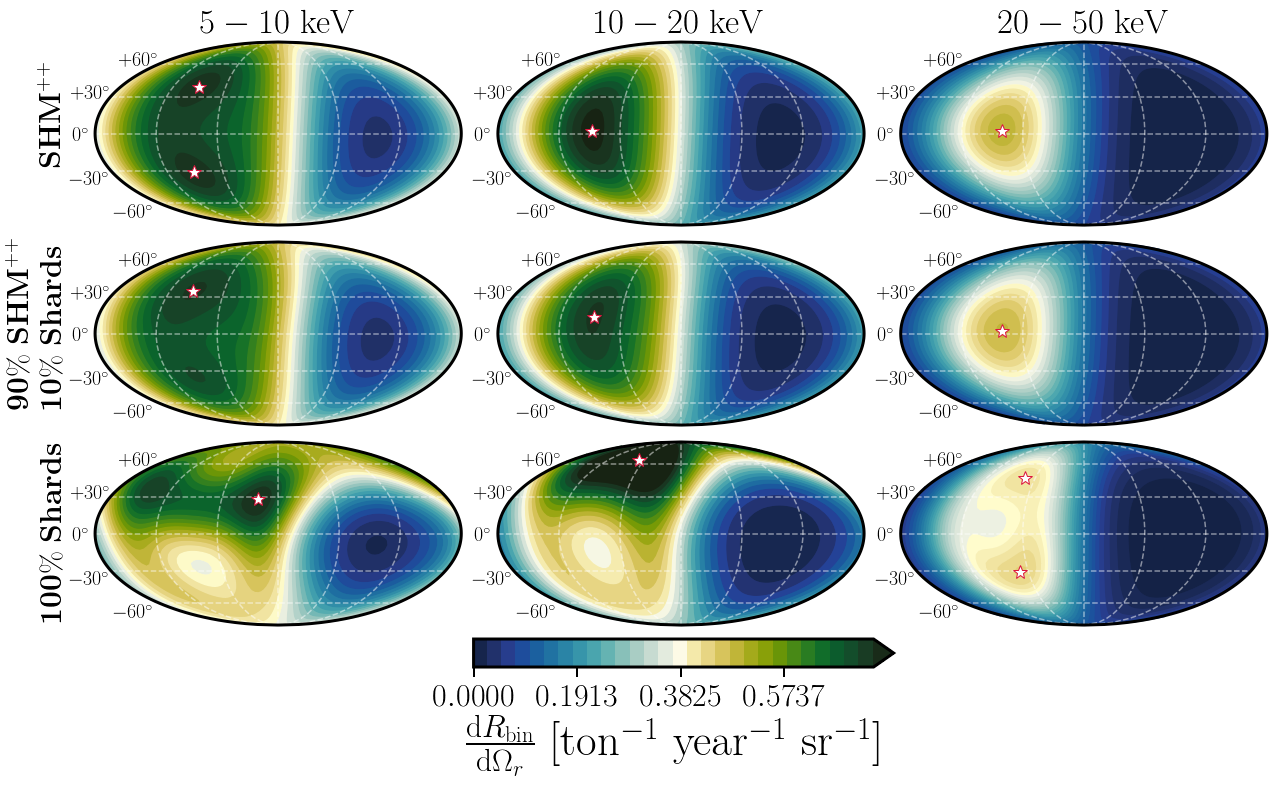

In [49]:

def MollweideMap1(ax,TH,PH,fv0,cmin,cmax,nlevels,cmap,tfs,PlotCygnus=False,gridlinecolor='k',GalacticPlane=False):
    plt.rcParams['axes.linewidth'] = 3
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif',size=15)

    ax.contour(rad2deg(PH), rad2deg(TH),fv0,nlevels,transform=ccrs.PlateCarree(),\
                cmap=cmap,vmin=cmin,vmax=cmax,linewidths=3,zorder=-1)    
    ax.contourf(rad2deg(PH), rad2deg(TH),fv0,nlevels,transform=ccrs.PlateCarree(),\
                cmap=cmap,vmin=cmin,vmax=cmax,linestyles='none',antialiased=True)

    gl = ax.gridlines(color=gridlinecolor,linewidth=1.5, linestyle='--',alpha=0.5)
    gl.ylocator = mticker.FixedLocator([-90,-60, -30, 0, 30, 60,90])
    ax.outline_patch.set_linewidth(3)
   

    tx = array([r'$-60^\circ$',r'$-30^\circ$',r'$0^\circ$',r'$+30^\circ$',r'$+60^\circ$']) 
    xtx = array([0.16,0.04,-0.02,0.04,0.17])
    ytx = array([0.08,0.26,0.49,0.72,0.9])
    
    for i in range(0,size(xtx)):
        plt.text(xtx[i],ytx[i],tx[i],transform=ax.transAxes,horizontalalignment='right',verticalalignment='center',fontsize=tfs)


    if PlotCygnus==True:
        ax.plot(-cyg[0:4,0],cyg[0:4,1],'-',color='crimson',transform=ccrs.PlateCarree())
        ax.plot(-cyg[4:,0],cyg[4:,1],'-',color='crimson',transform=ccrs.PlateCarree())
        ax.plot(-cyg[:,0],cyg[:,1],'.',color='k',ms=5,transform=ccrs.PlateCarree())

    if GalacticPlane==True:
        ax.plot([-181,181],[0,0],'-',color=gridlinecolor,lw=1.5,transform=ccrs.PlateCarree())
        ax.text(125,4,'Galactic',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=int(tfs*0.8))
        ax.text(135,-10,'plane',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=int(tfs*0.8))
    return


def find2max(dR):
    ni = shape(dR)[0]
    R0 = dR*1.0
    R1 = dR*1.0
    R0[1:int(ni/2),:] = 0.0
    R1[int(ni/2):,:] = 0.0
    imax1 = unravel_index(R0.argmax(), R0.shape)
    imax2 = unravel_index(R1.argmax(), R1.shape)
    return imax1,imax2


def find1max(dR):
    imax1 = unravel_index(dR.argmax(), dR.shape)
    return imax1



######
fig, axarr = plt.subplots(3, 3,figsize=(21,11))
gs = gridspec.GridSpec(3, 3)
gs.update(wspace=0.1,hspace=0.01)

cmap = cmocean.cm.delta
tit = [r'$5-10$ keV',r'$10-20$ keV',r'$20-50$ keV']

xi = 0.1
dR2 = (1-xi)*dR_map_smooth_s+xi*dR_map_shards_s

cmin = 0.0
cmax = around(amax(dR_map_shards_s),1)*0.85

nlevels = 30
tfs = 20

titfontsize = 35

ms = 15

for ibin in range(0,3): 
    dR = dR_map_smooth_s[:,:,ibin]*1.0
    ax = plt.subplot(gs[0,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR,cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    plt.title(tit[ibin],fontsize=titfontsize,y=1.03)
    if ibin==0:
        ax.annotate(r'{\bf SHM}$^{++}$', xy=(-0.15, 0.35), xycoords='axes fraction',fontsize=30,rotation=90)

    if ibin==0:
        imax1,imax2 = find2max(dR)
        ax.plot(ph[imax1[1]]*180/pi,th[imax1[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())
        ax.plot(ph[imax2[1]]*180/pi,th[imax2[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())
    else:
        imax1 = find1max(dR)
        ax.plot(ph[imax1[1]]*180/pi,th[imax1[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())

for ibin in range(0,3): 
    dR = dR2[:,:,ibin]*1.0
    ax = plt.subplot(gs[1,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR,cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    if ibin==0:
        ax.annotate(r'{\bf 90}\% {\bf SHM}$^{++}$', xy=(-0.24, 0.12), xycoords='axes fraction',fontsize=30,rotation=90)
        ax.annotate(r'{\bf 10}\% {\bf Shards}', xy=(-0.15, 0.12), xycoords='axes fraction',fontsize=30,rotation=90)

    imax1 = find1max(dR)
    ax.plot(ph[imax1[1]]*180/pi,th[imax1[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())


for ibin in range(0,3):
    dR = dR_map_shards_s[:,:,ibin]*1.0
    ax = plt.subplot(gs[2,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR,cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    if ibin==0:
        ax.annotate(r'{\bf 100}\% {\bf Shards}', xy=(-0.15, 0.05), xycoords='axes fraction',fontsize=30,rotation=90)
    if ibin==2:
        imax1,imax2 = find2max(dR)
        ax.plot(ph[imax1[1]]*180/pi,th[imax1[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())
        ax.plot(ph[imax2[1]]*180/pi,th[imax2[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())
    else:
        imax1 = find1max(dR)
        ax.plot(ph[imax1[1]]*180/pi,th[imax1[0]]*180/pi,'w*',mec='crimson',mew=1,ms=ms,transform=ccrs.PlateCarree())

# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="60%", height="7%", bbox_to_anchor=[295, -300, 700, 400]) 
norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm,cax=cbaxes,ticks=linspace(cmin,cmax,5),boundaries=linspace(cmin,cmax,nlevels),orientation='horizontal',extend='max')
f = plt.gcf().get_children()
cbar = f[3]
plt.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7,labelsize=32)
plt.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False,labelsize=32)
plt.gcf().text(0.37,-0.055,r'$\frac{\mathrm{d}R_{\rm bin}}{\mathrm{d}\Omega_r}$ [ton$^{-1}$ year$^{-1}$ sr$^{-1}$]',fontsize=45)
cbar1.solids.set_edgecolor("face")
cbar1.solids.set_rasterized(True) 

# save figure
plt.show()
pltname = 'Shards_Directional'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [45]:
def GetShardsMaps(irange):
    # Radon transform and rate
    dR = zeros(shape=(3,nn))
    fhat = zeros(shape=(nn))
    for ibin in range(0,nbins):
        E_r = E[ibin,:]
        v_min = MinimumWIMPSpeed(E_r,A,m_chi)
        for ie in range(0,ne):
            fhat = zeros(shape=(nn))
            for i in irange:
                v_s = velocities[i,:]
                sig_s = dispersions[i,:]
                fhat += weights[i]*fhat_Triaxial(v_min[ie],-1.0*q,day,sig_s,v_shift=v_s)
            dR[ibin,:] += diffRecoilRate_SI(E_r[ie],fhat,A,sigma_p,m_chi)
        print('bin =',ibin)

    # Convert list into Mollweide map
    dR_map = zeros(shape=(int(n/2),n,3))
    for ibin in range(0,3):
        ii = 0
        for i in range(0,int(n/2)):
            for j in range(0,n):
                dR_map[i,j,ibin] = dR[ibin,ii]
                ii = ii+1
        dR_map[:,:,ibin] = flipud(dR_map[:,:,ibin])     
    return dR_map

iS1 = [0]
iS2 = arange(1,3)
iRet = arange(3,10)
iPro = arange(10,25)
iLowE = arange(25,59)

dR_map_S1 = GetShardsMaps(iS1)
dR_map_S2 = GetShardsMaps(iS2)
dR_map_Ret = GetShardsMaps(iRet)
dR_map_Pro = GetShardsMaps(iPro)
dR_map_LowE = GetShardsMaps(iLowE)

dR_map_S1 = applyangres(dR_map_S1)
dR_map_S2 = applyangres(dR_map_S2)
dR_map_Ret = applyangres(dR_map_Ret)
dR_map_Pro = applyangres(dR_map_Pro)
dR_map_LowE = applyangres(dR_map_LowE)



bin = 0
bin = 1
bin = 2
bin = 0
bin = 1
bin = 2
bin = 0
bin = 1
bin = 2
bin = 0
bin = 1
bin = 2
/Users/ciaranohare/Work/Zaragoza/HaloSpin/code/HaloFuncs.py:61: RuntimeWarning: invalid value encountered in double_scalars
  *erfi(v_esc/(sqrt(2)*sigr)*sqrt(beta/(1-beta)))

bin = 0
bin = 1
bin = 2


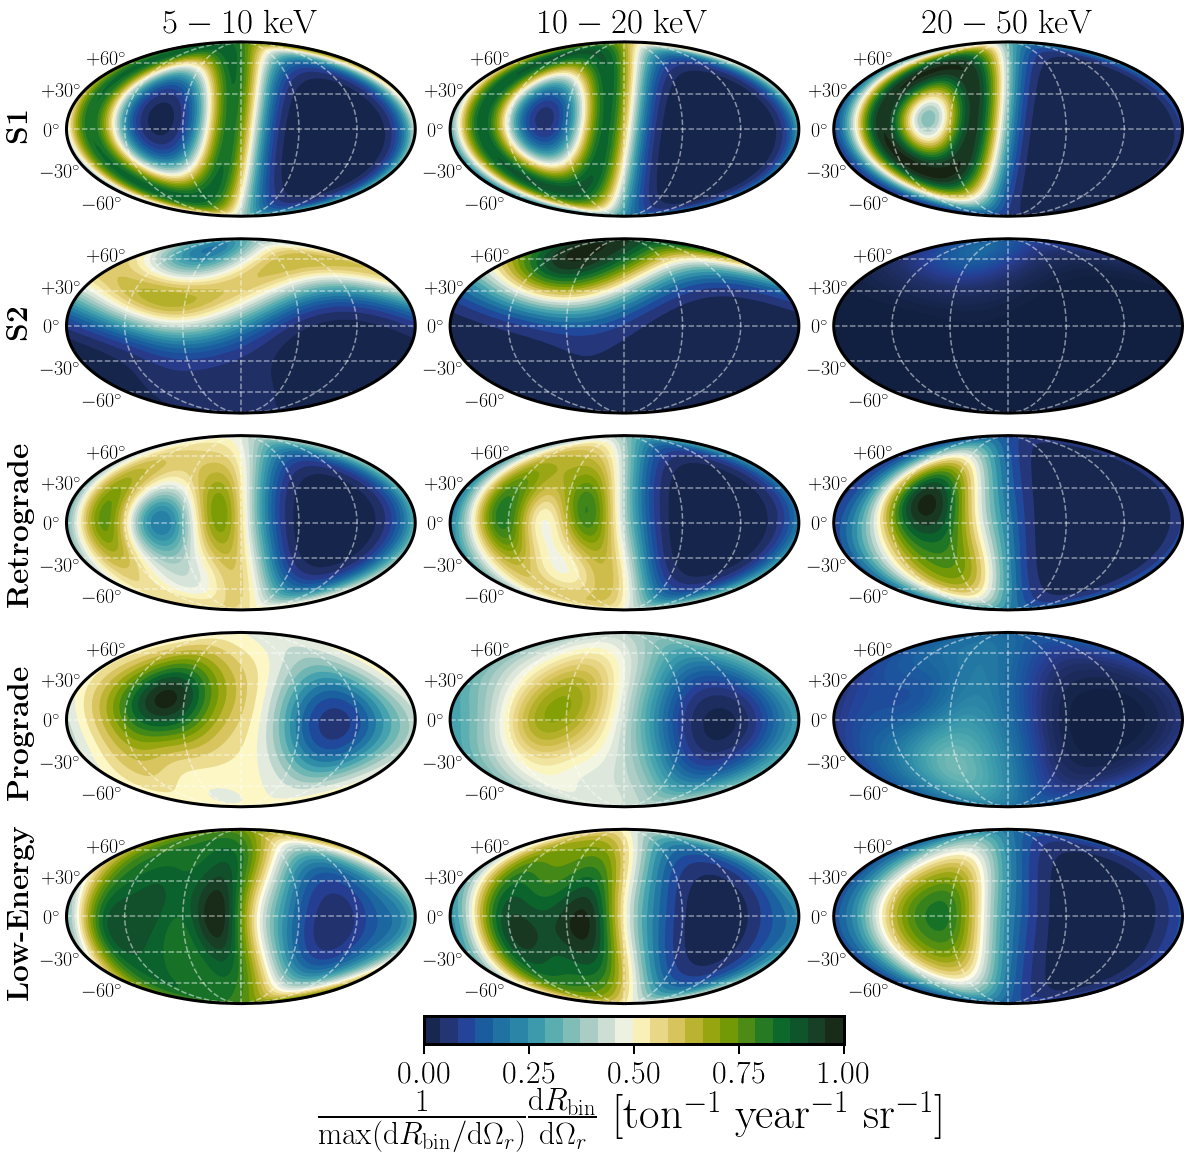

In [53]:

fig, axarr = plt.subplots(5, 3,figsize=(20,18))
gs = gridspec.GridSpec(5, 3)
gs.update(wspace=0.1,hspace=0.03)

#cmin = amin(dR_map_S2)
#cmax = amax(dR_map_S2)*0.5
nlevels = 25

for ibin in range(0,3): 
    cmin = amin(dR_map_S1)
    cmax = amax(dR_map_S1)
    dR = dR_map_S1[:,:,ibin]*1.0
    ax = plt.subplot(gs[0,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR,cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    plt.title(tit[ibin],fontsize=titfontsize,y=1.03)
    if ibin==0:
        ax.annotate(r'{\bf S1}', xy=(-0.17, 0.45), xycoords='axes fraction',fontsize=30,rotation=90)
        
for ibin in range(0,3): 
    cmin = amin(dR_map_S2)
    cmax = amax(dR_map_S2)
    dR = dR_map_S2[:,:,ibin]*1.0
    ax = plt.subplot(gs[1,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR,cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    if ibin==0:
        ax.annotate(r'{\bf S2}', xy=(-0.17, 0.45), xycoords='axes fraction',fontsize=30,rotation=90)

for ibin in range(0,3): 
    cmin = amin(dR_map_Ret)
    cmax = amax(dR_map_Ret)
    dR = dR_map_Ret[:,:,ibin]*1.0
    ax = plt.subplot(gs[2,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR,cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    if ibin==0:
        ax.annotate(r'{\bf Retrograde}', xy=(-0.17, 0.05), xycoords='axes fraction',fontsize=30,rotation=90)

for ibin in range(0,3): 
    cmin = amin(dR_map_Pro)
    cmax = amax(dR_map_Pro)
    dR = dR_map_Pro[:,:,ibin]*1.0
    ax = plt.subplot(gs[3,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR,cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    if ibin==0:
        ax.annotate(r'{\bf Prograde}', xy=(-0.17, 0.07), xycoords='axes fraction',fontsize=30,rotation=90)

for ibin in range(0,3): 
    cmin = amin(dR_map_LowE)
    cmax = amax(dR_map_LowE)
    dR = dR_map_LowE[:,:,ibin]*1.0
    ax = plt.subplot(gs[4,ibin],projection=ccrs.Mollweide())
    MollweideMap1(ax,TH,PH,dR,cmin,cmax,nlevels,cmap,tfs,gridlinecolor='w')
    if ibin==0:
        ax.annotate(r'{\bf Low-Energy}', xy=(-0.17, 0.05), xycoords='axes fraction',fontsize=30,rotation=90)

# # Custom colorbar
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cbaxes = inset_axes(ax, width="60%", height="7%", bbox_to_anchor=[265, -235, 700, 400]) 
norm = mpl.colors.Normalize(vmin=0.0,vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm,cax=cbaxes,ticks=linspace(0.0,1.0,5),boundaries=linspace(0.0,1.0,nlevels),orientation='horizontal')
f = plt.gcf().get_children()
cbar = f[3]
plt.tick_params(which='major',direction='out',width=2,length=10,right=True,top=False,pad=7,labelsize=32)
plt.tick_params(which='minor',direction='out',width=2,length=7,right=True,top=False,labelsize=32)
plt.gcf().text(0.3,0.02,r'$\frac{1}{\max(\mathrm{d}R_{\rm bin}/\mathrm{d}\Omega_r)}\frac{\mathrm{d} R_{\rm bin}}{\mathrm{d}\Omega_r}$ [ton$^{-1}$ year$^{-1}$ sr$^{-1}$]',fontsize=45)
cbar1.solids.set_edgecolor("face")
cbar1.solids.set_rasterized(True) 

# save figure
plt.show()
pltname = 'Shards_indiv_Directional'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

In [44]:
fig, axarr = plt.subplots(1, 1,figsize=(10,10))
gs = gridspec.GridSpec(1, 1)


levels = [-4,-1,0]
cols = cmocean.cm.phase(linspace(0,1,6))
cols = ['FireBrick','DarkBlue','Purple','DarkGreen','Blue']
cmaps = [cm.Reds,cm.Blues,cm.Purples,cm.Greens,cm.BuPu]
vmins = [-4.5,-4,-4.5,-4.5,-4.5]
vmaxs = [0.0,0.0,0.0,0.0,0.0]
alph = 0.8

idi = ['S1','S2','R','Ca','N']
zo = 5
for i in range(0,5): 
    mask1 = zeros(shape=nshards)==1
    for j in range(0,nshards):
        mask1[j] = names[j].startswith(idi[i])
    L = log(sum(fv_map_shards[:,:,mask1],axis=2))
    L = L-amax(L)
    ax = plt.subplot(gs[0],projection=ccrs.Mollweide())
    ax.contour(rad2deg(PH), rad2deg(TH),L,levels=levels,transform=ccrs.PlateCarree(),colors=cols[i],linestyles='-',linewidths=3,zorder=zo+1)
    L[L<-4] = nan
    ax.contourf(rad2deg(PH), rad2deg(TH),L,levels=10,vmin=vmins[i],vmax=vmaxs[i],transform=ccrs.PlateCarree(),cmap=cmaps[i],linestyles='none',alpha=alph,zorder=zo)
    zo -= 2
    
    

gridlinecolor='k'
gl = ax.gridlines(color=gridlinecolor,linewidth=1.5, linestyle='--',alpha=0.5,zorder=10)
gl.ylocator = mticker.FixedLocator([-90,-60, -30, 0, 30, 60,90])
ax.outline_patch.set_linewidth(3)

tx = array([r'$-60^\circ$',r'$-30^\circ$',r'$0^\circ$',r'$+30^\circ$',r'$+60^\circ$']) 
xtx = array([0.17,0.05,-0.01,0.05,0.18])
ytx = array([0.08,0.26,0.49,0.72,0.9])
    
for i in range(0,size(xtx)):
    plt.text(xtx[i],ytx[i],tx[i],transform=ax.transAxes,horizontalalignment='right',verticalalignment='center',fontsize=tfs)


ax.plot(-cyg[0:4,0],cyg[0:4,1],'-',color='yellow',transform=ccrs.PlateCarree(),zorder=10)
ax.plot(-cyg[4:,0],cyg[4:,1],'-',color='yellow',transform=ccrs.PlateCarree(),zorder=10)
ax.plot(-cyg[:,0],cyg[:,1],'.',color='yellow',markeredgecolor='k',ms=8,transform=ccrs.PlateCarree(),zorder=10)

ax.plot([-181,181],[0,0],'-',color=gridlinecolor,lw=1.5,transform=ccrs.PlateCarree(),zorder=10)
ax.text(122,5,'Galactic',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=int(tfs),zorder=10)
ax.text(132,-12,'plane',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=int(tfs),zorder=10)

plt.plot([0.32,0.55],[0.6,0.65],'-',color='k',transform=ax.transAxes,lw=4,zorder=10)
plt.plot([0.32,0.55],[0.6,0.65],'-',color=cols[0],transform=ax.transAxes,lw=2,zorder=10)
plt.text(0.55+0.01,0.65-0.03,r'{\bf S1}',color=cols[0],fontsize=30,transform=ax.transAxes)

plt.plot([0.45,0.55],[0.9,0.85],'-',color='k',transform=ax.transAxes,lw=4,zorder=10)
plt.plot([0.45,0.55],[0.9,0.85],'-',color=cols[1],transform=ax.transAxes,lw=2,zorder=10)
plt.text(0.55+0.01,0.85-0.04,r'{\bf S2}',color=cols[1],fontsize=30,transform=ax.transAxes)

plt.plot([0.33,0.55],[0.34,0.28],'-',color='k',transform=ax.transAxes,lw=4,zorder=10)
plt.plot([0.33,0.55],[0.34,0.28],'-',color=cols[2],transform=ax.transAxes,lw=2,zorder=10)
plt.text(0.55+0.01,0.29-0.05,r'{\bf Retrograde}',color=cols[2],fontsize=25,transform=ax.transAxes)

plt.plot([0.42,0.55],[0.15,0.13],'-',color='k',transform=ax.transAxes,lw=4,zorder=10)
plt.plot([0.42,0.55],[0.15,0.13],'-',color=cols[3],transform=ax.transAxes,lw=2,zorder=10)
plt.text(0.55+0.01,0.13-0.04,r'{\bf Prograde}',color=cols[3],fontsize=25,transform=ax.transAxes)


plt.show()
pltname = 'ShardsOnTheSky'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')

4.696522350821105